# imports

In [1]:
import os

base_dir = '/home/azam1/workspace/MultiModal/src/'
os.chdir(base_dir)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as distrib
import torch.distributions.transforms as transform
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
x = np.linspace(-4, 4, 1000)
z = np.array(np.meshgrid(x, x)).transpose(1, 2, 0)
z = np.reshape(z, [z.shape[0] * z.shape[1], -1])

In [3]:
class VAE(nn.Module):
    
    def __init__(self, encoder, decoder, encoder_dims, latent_dims, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.latent_dims = latent_dims
        self.encoder_dims = encoder_dims
        self.mu = nn.Linear(encoder_dims, latent_dims)
        self.sigma = nn.Sequential(
            nn.Linear(encoder_dims, latent_dims),
            nn.Softplus(),
            nn.Hardtanh(min_val=1e-4, max_val=5.))
        self.apply(self.init_parameters)
        self.device = device
    
    def init_parameters(self, m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
        
    def encode(self, x):
        x = self.encoder(x)
        mu = self.mu(x)
        sigma = self.sigma(x)
        return mu, sigma
    
    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        # Encode the inputs
        z_params = self.encode(x)
        # Obtain latent samples and latent loss
        z_tilde, kl_div = self.latent(x, z_params)
        # Decode the samples
        x_tilde = self.decode(z_tilde)
        return x_tilde, kl_div
    
    def latent(self, x, z_params):
        n_batch = x.size(0)
        # Retrieve mean and var
        mu, sigma = z_params
        # Re-parametrize
        q = distrib.Normal(torch.zeros(mu.shape[1]), torch.ones(sigma.shape[1]))
        z = (sigma * q.sample((n_batch, )).to(self.device)) + mu
        # Compute KL divergence
        kl_div = -0.5 * torch.sum(1 + sigma - mu.pow(2) - sigma.exp())
        kl_div = kl_div / n_batch
        return z, kl_div

In [4]:
def construct_encoder_decoder(nin, n_latent = 64, n_hidden = 512, n_classes = 1):
    # Encoder network
    encoder = nn.Sequential(
                nn.Linear(nin, n_hidden),
                nn.ReLU(True),
                nn.Linear(n_hidden, n_hidden),
                nn.ReLU(True),
                nn.Linear(n_hidden, n_hidden))
    # Decoder network
    decoder = nn.Sequential(
                nn.Linear(n_latent, n_hidden),
                nn.ReLU(True),
                nn.Linear(n_hidden, n_hidden),
                nn.ReLU(True),
                nn.Linear(n_hidden, nin * n_classes),
                nn.Sigmoid())
    return encoder, decoder

In [5]:
def binary_loss(x_tilde, x):
    return F.binary_cross_entropy(x_tilde, x, reduction='none').sum(dim = 0)

def multinomial_loss(x_logit, x):
    batch_size = x.shape[0]
    # Reshape input
    x_logit = x_logit.view(batch_size, num_classes, x.shape[1], x.shape[2], x.shape[3])
    # Take softmax
    x_logit = F.log_softmax(x_logit, 1)
    # make integer class labels
    target = (x * (num_classes - 1)).long()
    # computes cross entropy over all dimensions separately:
    ce = F.nll_loss(x_logit, target, weight=None, reduction='none')
    return ce.sum(dim = 0)*100

def reconstruction_loss(x_tilde, x, num_classes=1, average=True):
    if (num_classes == 1):
        loss = binary_loss(x_tilde, x.view(x.size(0), -1))
    else:
        loss = multinomial_loss(x_tilde, x)
    if (average):
        loss = loss.sum() / x.size(0)
    return loss

In [19]:
from data.loader import get_loader

batch_size =64
train_loader = get_loader('cococap', batch_size, train=True)
test_loader = get_loader('cococap', batch_size, train=False)

loading annotations into memory...
Done (t=0.57s)
creating index...
index created!


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


cache exists: /home/azam1/workspace/data/feather/coco_train.feather. skip caching.
load cache: /home/azam1/workspace/data/feather/coco_train.feather
loading annotations into memory...
Done (t=1.26s)
creating index...
index created!


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


cache exists: /home/azam1/workspace/data/feather/coco_val.feather. skip caching.
load cache: /home/azam1/workspace/data/feather/coco_val.feather


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


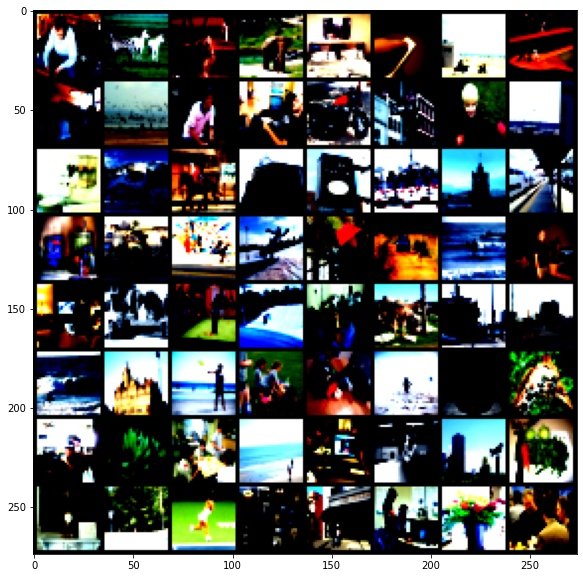

In [21]:
%matplotlib inline
from torchvision.utils import make_grid


# Select a random set of fixed data
fixed_batch, fixed_targets = next(iter(test_loader))
# fixed_batch = fixed_batch[:64, :, :, :]
# fixed_targets = fixed_targets[:64, :]
grid = make_grid(fixed_batch)
plt.figure(figsize=(10, 10))
plt.imshow(grid.permute(1, 2, 0).numpy())

In [28]:
# Using Bernoulli or Multinomial loss
num_classes = 1
# Number of hidden and latent
n_hidden = 1024
n_latent = 256
# Compute input dimensionality
nin_1 = fixed_batch.shape[1] * fixed_batch.shape[2] * fixed_batch.shape[3]
nin =  nin_1 + fixed_targets.shape[1]
# Construct encoder and decoder
encoder, decoder = construct_encoder_decoder(nin, n_hidden = n_hidden, n_latent = n_latent, n_classes = num_classes)
# Build the VAE model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'device for training: {device}')
model = VAE(encoder, decoder, n_hidden, n_latent, device)
# Create optimizer algorithm
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# Add learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.99995)

device for training: cuda


  0%|          | 0/1294 [00:00<?, ?it/s]

<Figure size 720x720 with 0 Axes>

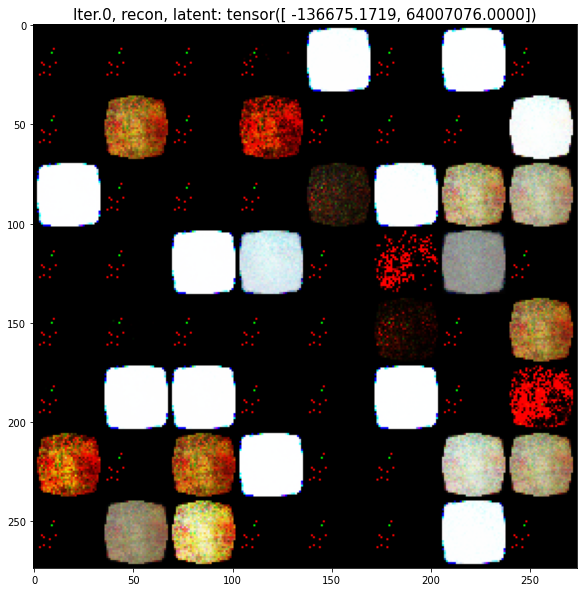

  0%|          | 0/1294 [00:00<?, ?it/s]

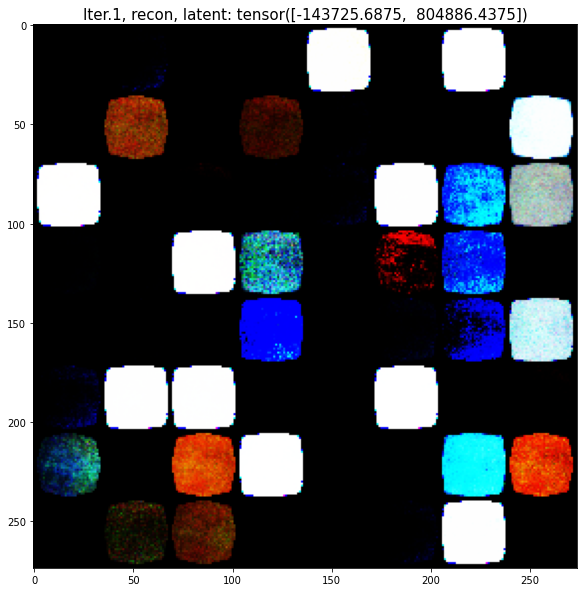

  0%|          | 0/1294 [00:00<?, ?it/s]

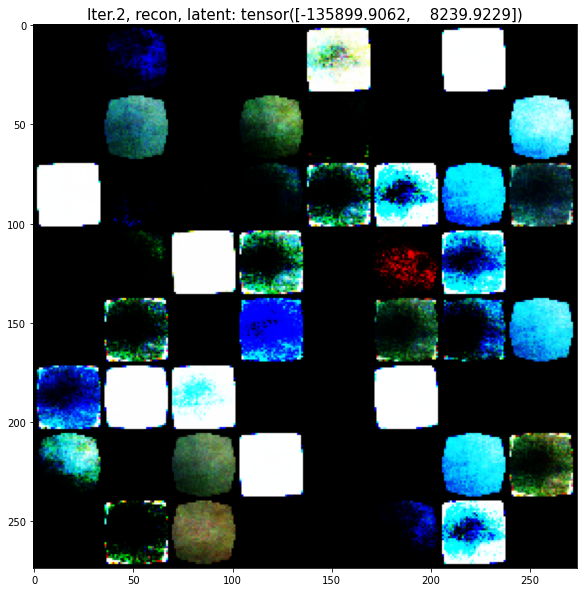

  0%|          | 0/1294 [00:00<?, ?it/s]

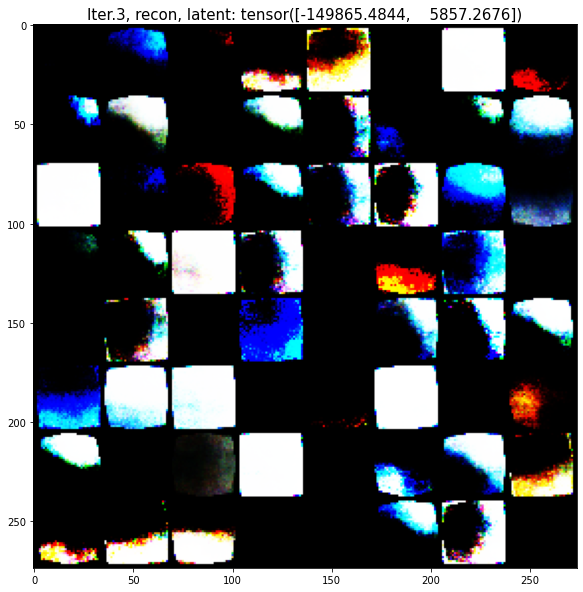

  0%|          | 0/1294 [00:00<?, ?it/s]

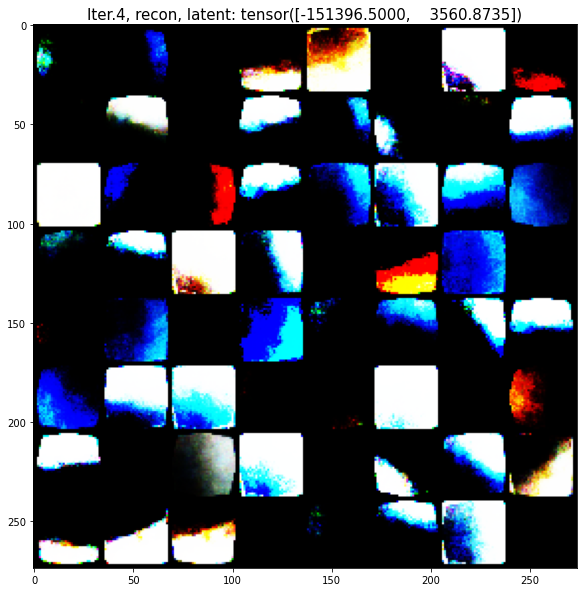

  0%|          | 0/1294 [00:00<?, ?it/s]

In [ ]:
%matplotlib inline
def train_vae(model, optimizer, scheduler, train_loader, fixed_batch, model_name='basic', epochs=50, plot_it=1, subsample=5000, flatten=True):
    # Losses curves
    losses = torch.zeros(epochs, 2)
    # Beta-warmup
    beta = 0
    # Plotting
    ims = []
    fig = plt.figure(figsize=(10, 10))
    # Main optimization loop
    
    for it in range(epochs):
        it_loss = torch.Tensor([2])
        # Update our beta
        beta = 1. * (it / float(epochs))
        n_batch = 0.
        # Evaluate loss and backprop
        for batch_idx, (x1, x2) in tqdm(enumerate(train_loader), total=len(train_loader)):

            x1 = x1.to(device)
            x2 = x2.to(device)

            if (batch_idx * batch_size) > subsample:
                break
            # Flatten input data
            if (flatten):
                x1 = x1.view(-1, nin_1)
            assert x1.size(0) == x2.size(0)
            x = torch.cat((x1, x2), dim=1)

            # Pass through VAE
            x_tilde, loss_latent = model(x)

            # Compute reconstruction loss
            loss_recons = reconstruction_loss(x_tilde, x, num_classes)

            # Evaluate loss and backprop
            loss = loss_recons + (beta * loss_latent)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

            losses[it, 0] += loss_recons.item()
            losses[it, 1] += loss_latent.item()
            n_batch += 1.

        losses[it, :] /= n_batch
        if (it % plot_it == 0):
            # Encode our fixed batch
            samples = fixed_batch
            if (flatten):
                samples = fixed_batch.view(-1, nin_1)
            samples = torch.cat((samples, fixed_targets), dim=1)
            samples = samples.to(device)
            samples_tilde, _ = model(samples)
            x_tilde = samples_tilde[:, :nin_1]
            # if (num_classes > 1):
                # Find largest class logit
                # tmp = x_tilde.view(-1, num_classes, *x[0].shape[1:]).max(dim=1)[1]
                # x_tilde = tmp.float() / (num_classes - 1.)
            grid = make_grid(x_tilde.view_as(fixed_batch))
            plt.figure(figsize=(10, 10))
            plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
#             ims.append(plot_batch(x_tilde.detach().cpu().view_as(fixed_batch)))
            plt.title(f'Iter.{it}, recon, latent: {losses[it]}', fontsize=15);
            plt.show()
    return losses
            
# Launch our optimization
losses_kld = train_vae(model.to(device), optimizer, scheduler, train_loader, fixed_batch, 
                       model_name='basic', epochs=100)

In [ ]:
from scipy.special import logsumexp

def evaluate_nll_bpd(data_loader, model, batch = 500, R = 5):
    model.eval()
    # Set of likelihood tests
    likelihood_test = []
    # Go through dataset
    for batch_idx, (x, _) in enumerate(data_loader):
        x = x.to(device)
        for j in range(x.shape[0]):
            a = []
            for r in range(0, R):
                cur_x = x[j].unsqueeze(0)
                # Repeat it as batch
                x = cur_x.expand(batch, *cur_x.size()[1:]).contiguous()
                x = x.view(batch, -1)
                x_tilde, kl_div = model(x)
                rec = reconstruction_loss(x_tilde, x, average=False)
                a_tmp = (rec + kl_div)
                a.append(- a_tmp.cpu().data.numpy())
            # calculate max
            a = np.asarray(a)
            a = np.reshape(a, (a.shape[0] * a.shape[1], 1))
            likelihood_x = logsumexp(a)
            likelihood_test.append(likelihood_x - np.log(len(a)))
    likelihood_test = np.array(likelihood_test)
    nll = - np.mean(likelihood_test)
    # Compute the bits per dim (but irrelevant for binary data)
    bpd = nll / (np.prod(nin) * np.log(2.))
    return nll, bpd


(0.0, 50.0)

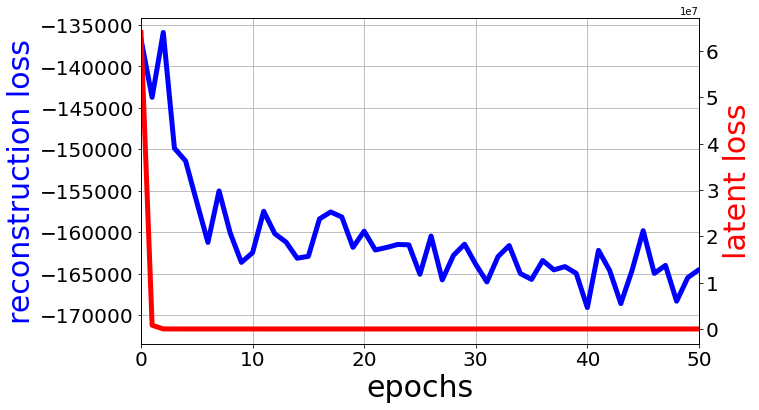

In [30]:
# Plot final loss
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
fontsize=30
ax1.plot(losses_kld[:, 0].numpy(), color='b', linewidth=5)
ax2.plot(losses_kld[:, 1].numpy(), color='r', linewidth=5)
ax1.set_xlabel('epochs', fontsize=fontsize)
ax1.set_ylabel('reconstruction loss', fontsize=fontsize, color='blue')
ax2.set_ylabel('latent loss', fontsize=fontsize, color='red')
ax1.xaxis.set_tick_params(labelsize=fontsize-10)
ax1.yaxis.set_tick_params(labelsize=fontsize-10)
ax2.yaxis.set_tick_params(labelsize=fontsize-10)
ax1.grid()
ax1.set_xlim(left=0, right=50)

In [ ]:
# Plot final loss
plt.figure()
plt.plot(losses_kld[:, 0].numpy());
# Evaluate log-likelihood and bits per dim
nll, _ = evaluate_nll_bpd(test_loader, model)
print('Negative Log-Likelihood : ' + str(nll))
